# Домашняя работа 2. EM-алгоритм и kallisto

Модифицируйте EM-алгоритм таким образом, чтобы он находил не два, а три кластера на наших данных

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


from scipy import random
from scipy.stats import multivariate_normal

In [4]:
#I decided to check if it is fine for 3 clusters; 
#random dataset generation, from https://github.com/mr-easy/GMM-EM-Python/blob/master/EM_for_2D_GMM.ipynb 
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    mean = random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    if(dim == 2):
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True) 
    return x

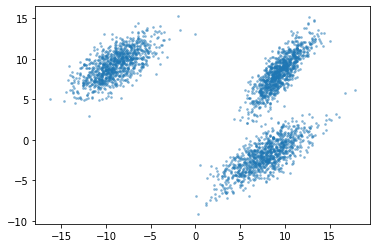

In [10]:
X = gen_data(k=3, dim=2, points_per_cluster=1000)

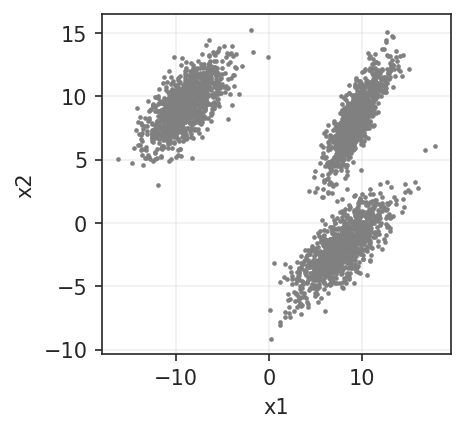

In [30]:
sns.set_style("ticks")
df = pd.DataFrame({'x1': X[:,0],'x2': X[:,1]})#pd.read_csv("EM_dataset.csv")
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, color="grey", linewidth=0, ax=ax)
ax.grid(alpha=0.3)

Модифицируйте EM-алгоритм таким образом, чтобы он находил не два, а три кластера на наших данных.


Система описывается следующими параметрами
$\theta := \phi1,\phi2, \mu_1, \sigma_1, \mu_2, \sigma_2, \mu_3, \sigma_3$. Зададим их изначально случайно.

In [32]:
#np.random.seed(21)

def get_random_psd(n=2):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())

    
phi1 = np.random.uniform(0, 1)
params = {
    "phi1" : phi1, # Доля точек, принадлежащих к кластеру 1
    "phi2" : np.random.uniform(0, 1-phi1), # Доля точек, принадлежащих к кластеру 1


    "mu1" : np.random.normal(0, 1, size=2), # Центр распределения 1
    "mu2" : np.random.normal(0, 1, size=2), # Центр распределения 2
    "mu3" : np.random.normal(0, 1, size=2), # Центр распределения 2
    
    "sigma1": get_random_psd(), # У 2d Гауссианы таким образом задаётся дисперсия
    "sigma2" : get_random_psd(), # У 2d Гауссианы таким образом задаётся дисперсия
    "sigma3" : get_random_psd() # У 2d Гауссианы таким образом задаётся дисперсия
}

for param in params:
  print(f"{param}:")
  print(params[param], "\n")

phi1:
0.7168777460707686 

phi2:
0.17707961865956717 

mu1:
[-1.9432441   1.45221239] 

mu2:
[ 0.65116243 -0.72264542] 

mu3:
[ 0.1503722  -0.87457849] 

sigma1:
[[1.95666837 1.53841018]
 [1.53841018 1.68981419]] 

sigma2:
[[ 2.00182787 -1.92778052]
 [-1.92778052  2.34267809]] 

sigma3:
[[ 1.62329042 -1.23800482]
 [-1.23800482  2.28138133]] 



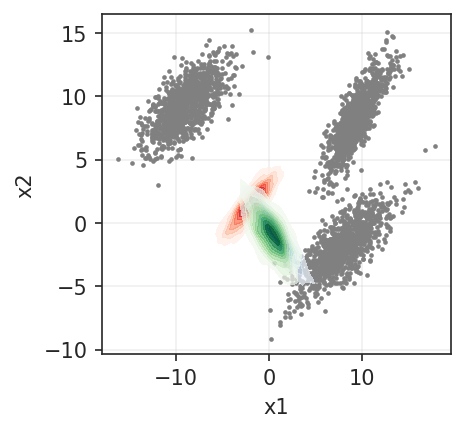

In [33]:
import scipy.stats as stats

hist1 = stats.multivariate_normal(params["mu1"], params["sigma1"]).rvs(size=1000)
hist2 = stats.multivariate_normal(params["mu2"], params["sigma2"]).rvs(size=1000)
hist3 = stats.multivariate_normal(params["mu3"], params["sigma3"]).rvs(size=1000)


fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, linewidth=0, ax=ax, color="grey")
sns.kdeplot(x=hist1[:, 0], y=hist1[:, 1], ax=ax, cmap="Reds", fill=True, alpha=0.7)
sns.kdeplot(x=hist2[:, 0], y=hist2[:, 1], ax=ax, cmap="Blues", fill=True, alpha=0.7)
sns.kdeplot(x=hist3[:, 0], y=hist3[:, 1], ax=ax, cmap="Greens", fill=True, alpha=0.7)
ax.grid(alpha=0.3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


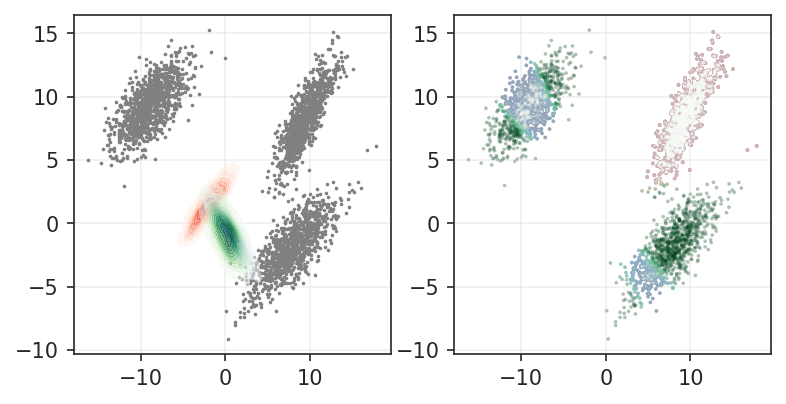

In [35]:
from scipy.special import logsumexp

X = df.values

def E_step(X, params, draw=False):
  LogLikelihood = A = np.log([
      stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(X), 
      stats.multivariate_normal(params["mu2"], params["sigma2"]).pdf(X),
      stats.multivariate_normal(params["mu3"], params["sigma3"]).pdf(X)
  ])
  logPrior = B = np.log([params["phi1"], params["phi2"],  1-(params["phi1"]+params["phi2"])])
  logPosterior = D = logPrior + LogLikelihood.T
  RealSoftMax = C = logsumexp(logPosterior, axis=1)
  probabilities = np.exp(logPosterior - np.array([RealSoftMax]).T)

  if draw:
    hist1 = stats.multivariate_normal(params["mu1"], params["sigma1"]).rvs(size=1000)
    hist2 = stats.multivariate_normal(params["mu2"], params["sigma2"]).rvs(size=1000)
    hist3 = stats.multivariate_normal(params["mu3"], params["sigma3"]).rvs(size=1000)

    fig, axes = plt.subplots(figsize=(6, 3), dpi=150, ncols=2)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=probabilities[:, 0], linewidth=0,
                    palette="Reds", 
                    ax=axes[1], s=3, alpha=0.99)
    X1=X.copy()
    X2=X.copy()
    sns.scatterplot(x=X1[:, 0], y=X1[:, 1], hue=probabilities[:, 1], linewidth=0,
                    palette="Blues", 
                    ax=axes[1], s=3, alpha=0.6)
    sns.scatterplot(x=X2[:, 0], y=X2[:, 1], hue=probabilities[:, 2], linewidth=0,
                    palette="Greens", 
                    ax=axes[1], s=3, alpha=0.3)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], linewidth=0, ax=axes[0], s=3, alpha=1, color="grey")
    sns.kdeplot(x=hist1[:, 0], y=hist1[:, 1], ax=axes[0], cmap="Reds", fill=True, alpha=0.5)
    sns.kdeplot(x=hist2[:, 0], y=hist2[:, 1], ax=axes[0], cmap="Blues", fill=True, alpha=0.5)
    sns.kdeplot(x=hist3[:, 0], y=hist3[:, 1], ax=axes[0], cmap="Greens", fill=True, alpha=0.5)
    axes[0].grid(alpha=0.3)
    axes[1].grid(alpha=0.3)
    axes[1].legend().remove()
#    axes[0].set_xlim(-4, 4)
#    axes[1].set_xlim(-4, 4)
#    axes[0].set_ylim(-4, 4)
#    axes[1].set_ylim(-4, 4)
    plt.show()

  return RealSoftMax, probabilities
total_prob, probabilities = E_step(X, params, draw=True)

In [36]:
def M_step(X, params, probabilities):
  prob_1 = probabilities[:, 0]
  prob_2 = probabilities[:, 1]
  prob_3 = probabilities[:, 2]

  # Вычисление новых значений
  # Пропорция = prior
  phi1 = prob_1.sum() / len(X)
  phi2 = prob_2.sum() / len(X)
#  phi3 = prob_3.sum() / len(X)

  # Среднее
  mu1 = prob_1.dot(X) / np.sum(prob_1)
  mu2 = prob_2.dot(X) / np.sum(prob_2)
  mu3 = prob_3.dot(X) / np.sum(prob_3)

  # Дисперсия
  sigma1 = (X - mu1).T.dot((X - mu1) * np.array([prob_1]).T) / np.sum(prob_1)
  sigma2 = (X - mu2).T.dot((X - mu2) * np.array([prob_2]).T) / np.sum(prob_2)
  sigma3 = (X - mu3).T.dot((X - mu3) * np.array([prob_3]).T) / np.sum(prob_3)

  return {
      "phi1" : phi1, "phi2" : phi2,
      "mu1" : mu1, "mu2" : mu2,"mu3" : mu3,
      "sigma1": sigma1, "sigma2": sigma2, "sigma3": sigma2
  }

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


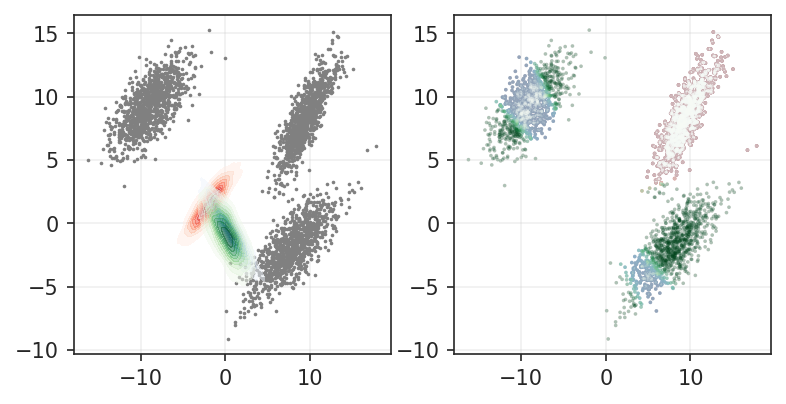

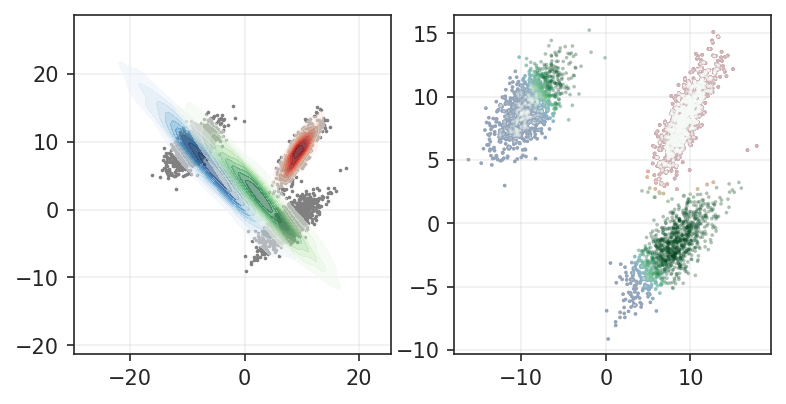

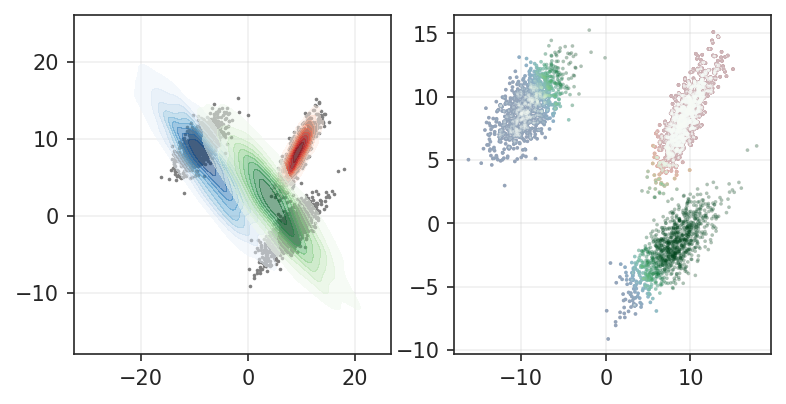

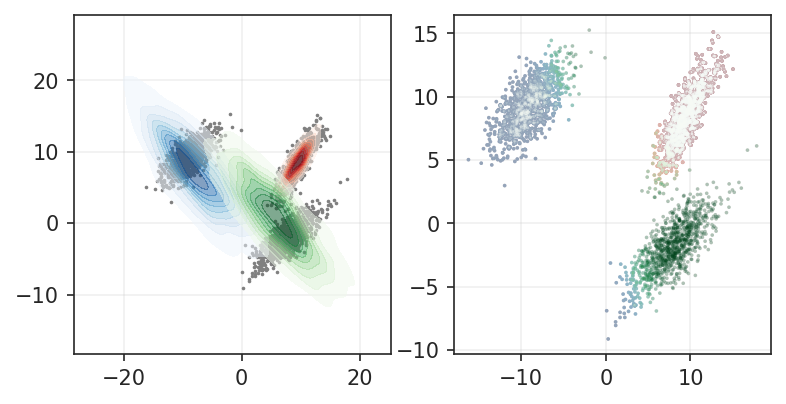

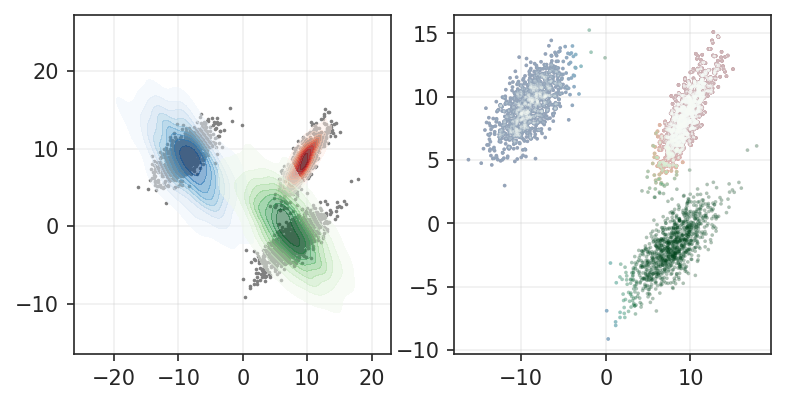

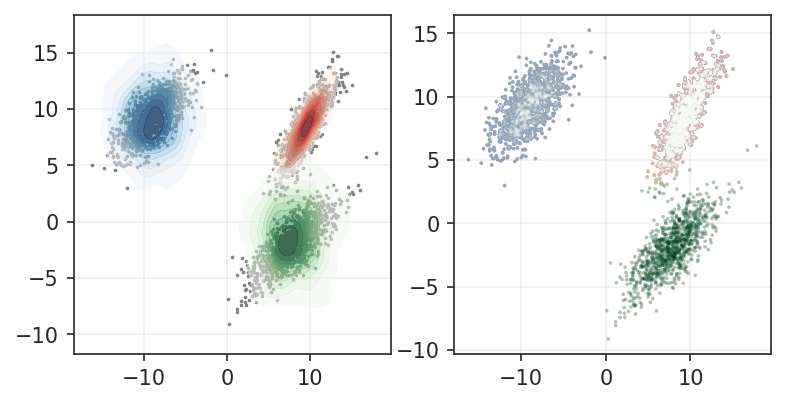

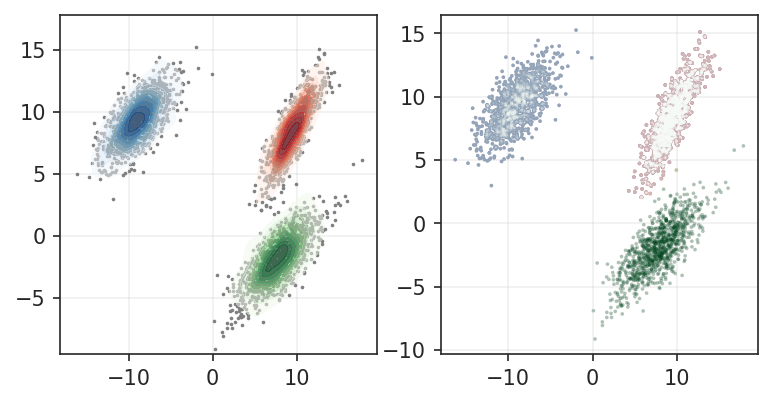

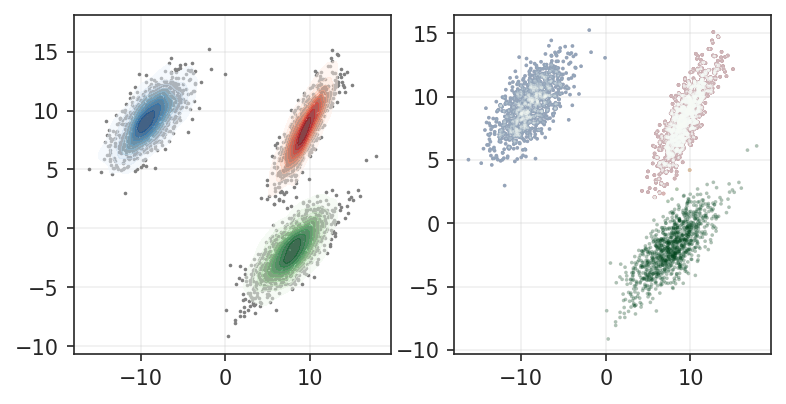

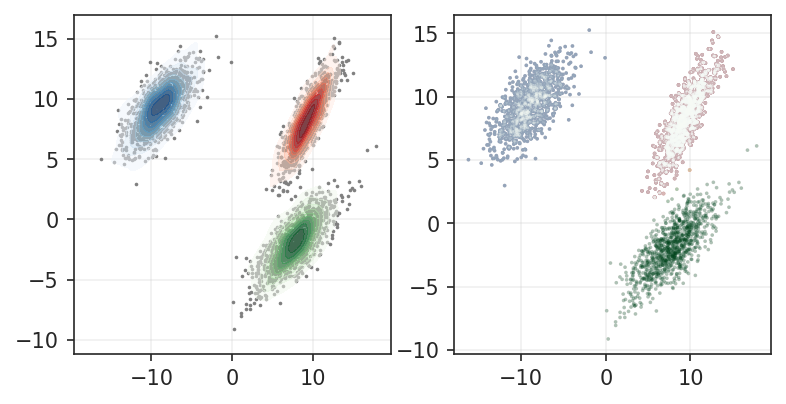

In [37]:
def run_EM(X, params, draw=False):
    import imageio
    avg_allprob = []

    while True:
        allprob, probabilities = E_step(X, params, draw=draw)
        avg_allprob.append(np.mean(allprob))
        if len(avg_allprob) > 2 and abs(avg_allprob[-1] - avg_allprob[-2]) < 0.00001:
            break
        params = M_step(X, params, probabilities)
        
    loglikelihood, probabilities = E_step(X, params)
    forecasts = np.argmax(probabilities, axis=1)

    return forecasts, probabilities, avg_allprob

pred, prob, allprob = run_EM(X, params, draw=True)

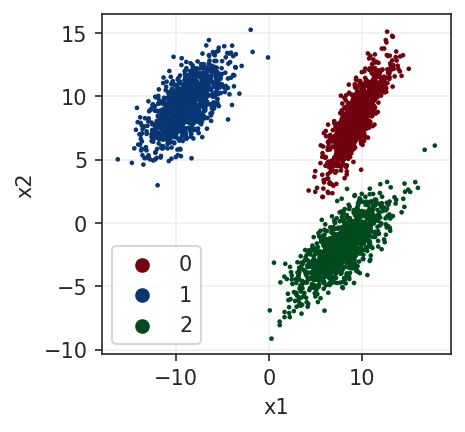

In [38]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, linewidth=0, ax=ax, hue=pred,
                palette={0: sns.color_palette("Reds", n_colors=50)[-1],
                         1: sns.color_palette("Blues", n_colors=50)[-1],
                         2: sns.color_palette("Greens", n_colors=50)[-1]})
ax.grid(alpha=0.3)

### Теперь для изначального датасета

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=17mf6RUEFOJ19t2zNuFlswSUs7MODwLlk
To: /content/EM_dataset.csv
100% 12.6k/12.6k [00:00<00:00, 14.4MB/s]


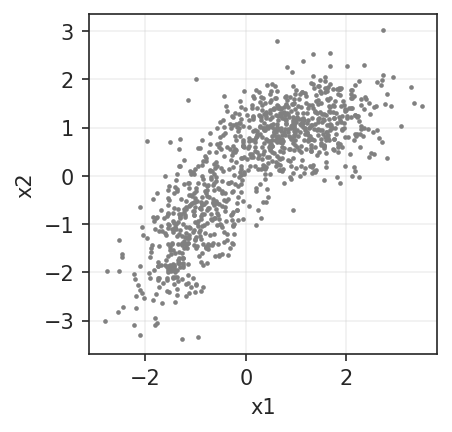

In [41]:
!gdown --id 17mf6RUEFOJ19t2zNuFlswSUs7MODwLlk

sns.set_style("ticks")
df = pd.read_csv("EM_dataset.csv")
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, color="grey", linewidth=0, ax=ax)
ax.grid(alpha=0.3)

In [42]:
phi1 = np.random.uniform(0, 1)
params = {
    "phi1" : phi1, # Доля точек, принадлежащих к кластеру 1
    "phi2" : np.random.uniform(0, 1-phi1), # Доля точек, принадлежащих к кластеру 1


    "mu1" : np.random.normal(0, 1, size=2), # Центр распределения 1
    "mu2" : np.random.normal(0, 1, size=2), # Центр распределения 2
    "mu3" : np.random.normal(0, 1, size=2), # Центр распределения 2
    
    "sigma1": get_random_psd(), # У 2d Гауссианы таким образом задаётся дисперсия
    "sigma2" : get_random_psd(), # У 2d Гауссианы таким образом задаётся дисперсия
    "sigma3" : get_random_psd() # У 2d Гауссианы таким образом задаётся дисперсия
}

for param in params:
  print(f"{param}:")
  print(params[param], "\n")

phi1:
0.8621364103691432 

phi2:
0.09904824687577493 

mu1:
[-0.05223766  0.25460817] 

mu2:
[ 0.73836026 -0.10550112] 

mu3:
[ 0.76214995 -0.32227344] 

sigma1:
[[ 1.14469102 -0.72288631]
 [-0.72288631  4.02140292]] 

sigma2:
[[ 6.46211231 -0.78169017]
 [-0.78169017  0.35527867]] 

sigma3:
[[ 0.15798443 -0.38704603]
 [-0.38704603  3.17497907]] 



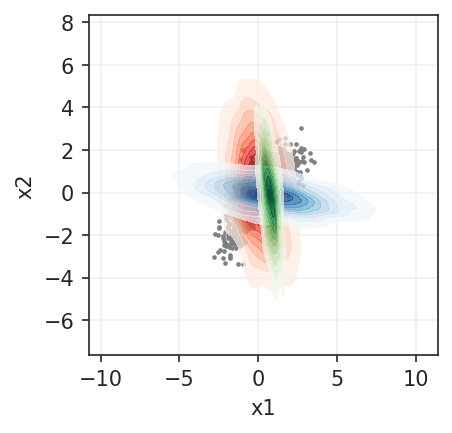

In [43]:
import scipy.stats as stats

hist1 = stats.multivariate_normal(params["mu1"], params["sigma1"]).rvs(size=1000)
hist2 = stats.multivariate_normal(params["mu2"], params["sigma2"]).rvs(size=1000)
hist3 = stats.multivariate_normal(params["mu3"], params["sigma3"]).rvs(size=1000)


fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, linewidth=0, ax=ax, color="grey")
sns.kdeplot(x=hist1[:, 0], y=hist1[:, 1], ax=ax, cmap="Reds", fill=True, alpha=0.7)
sns.kdeplot(x=hist2[:, 0], y=hist2[:, 1], ax=ax, cmap="Blues", fill=True, alpha=0.7)
sns.kdeplot(x=hist3[:, 0], y=hist3[:, 1], ax=ax, cmap="Greens", fill=True, alpha=0.7)
ax.grid(alpha=0.3)

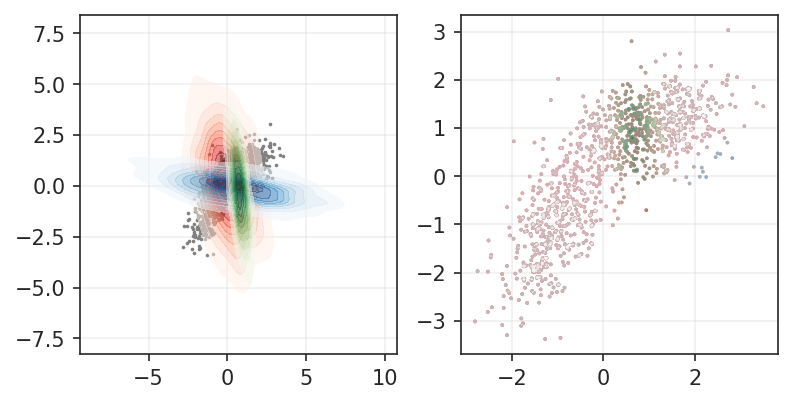

In [44]:
X = df.values
total_prob, probabilities = E_step(X, params, draw=True)

In [45]:
pred, prob, allprob = run_EM(X, params, draw=True)

Output hidden; open in https://colab.research.google.com to view.

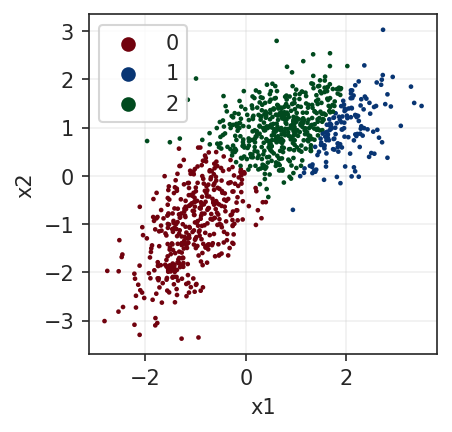

In [46]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, linewidth=0, ax=ax, hue=pred,
                palette={0: sns.color_palette("Reds", n_colors=50)[-1],
                         1: sns.color_palette("Blues", n_colors=50)[-1],
                         2: sns.color_palette("Greens", n_colors=50)[-1]})
ax.grid(alpha=0.3)

## Kallisto

В отличие от других подходов, в kallisto отсутствует стадия выравнивания прочтений на референсный геном или транскриптом. Данный подход строит граф де Брёйна из k-меров транскриптома, после k-меры прочтений образуют пути в этом графе. Основываясь на этих путях, производится максимально правдоподобная оценка экспрессий различных транскриптов.

Подробнее про работу метода можно прочитать <a href="https://bioinfo.iric.ca/understanding-how-kallisto-works/#:~:text=The%20idea%20behind%20kallisto%20is,(not%20the%20whole%20genome)." target="_blank">здесь</a>. Первым шагом мы загрузим kallisto из git-репозитория и установим эту программу.

In [ ]:
!git clone https://github.com/pachterlab/kallisto.git
!apt-get install autoconf
!cd kallisto && mkdir build && cd build && cmake .. && make

Теперь смоделируем следующую ситуацию:

1. У нас есть линейный геном, который состоит из $N_{blocks}$ блоков длиной $l_{block}$,
2. У нас есть $M$ транскриптов, каждый из которых включает несколько из геномных блоков,
3. Для каждого из транскриптов известен его уровень экспрессии $E_i$ в количестве молекул РНК. Каждая молекула РНК генерирует $l_{t} / 1000$ прочтений.

Давайте сгенерируем такой референсный транскриптом, а также прочтения, которые будут генерироваться при таком *in silico* RNA-Seq-эксперименте. Будем считать, что все прочтения были идеальными, качество у них `I`.

In [ ]:
# Generation of sequence
N_blocks = 10
l_block = 5000
transcripts = {
    "A" : [0, 1, 2],
    "B" : [1, 2, 3],
    "C" : [1, 4, 5],
    "D" : [5],
    "E" : [5, 6],
    "F" : [8, 9]
}

def generate_random_sequence(l):
  from random import choice
  return "".join([choice(["A", "T", "G", "C"]) for i in range(l)])

genome_blocks = dict(zip(range(10), [generate_random_sequence(l_block) for i in range(10)]))

# Generation of reference transcriptome
transcript_sequences = {}
with open("transcriptome.fasta", "w") as f:
  for transcript in transcripts:
    transcript_sequences[transcript] = "".join([genome_blocks[i] for i in transcripts[transcript]])
    f.write(f">{transcript}\n{transcript_sequences[transcript]}\n")

In [ ]:
# Generation of reads
l_read = 100
E = {
    "A" : 100,
    "B" : 100,
    "C" : 30,
    "D" : 0,
    "E" : 20,
    "F" : 10
}

from random import randint
with open("reads.fastq", "w") as f:
  counter = 0
  for transcript in E:
    for i in range(E[transcript]):
      for j in range(len(transcript_sequences[transcript]) // 1000):
        read_start = randint(0, len(transcript_sequences[transcript]) - (l_read + 1))
        quality = "I" * l_read
        f.write(f"@read_{counter}\n{transcript_sequences[transcript][read_start:(read_start + l_read)]}\n+\n{quality}\n")
        counter += 1

Теперь создадим индекс с нашим референсом при помощи `kallisto index`:

In [ ]:
!./kallisto/build/src/kallisto index -i transcriptome.idx transcriptome.fasta


[build] loading fasta file transcriptome.fasta
[build] k-mer length: 31
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 8 contigs and contains 44940 k-mers 



А теперь подсчитаем наши экспрессии при помощи `kallisto quant`:

In [ ]:
l = l_read
!./kallisto/build/src/kallisto quant -i transcriptome.idx -o results --single -l $l -s 1 reads.fastq


[quant] fragment length distribution is truncated gaussian with mean = 100, sd = 1
[index] k-mer length: 31
[index] number of targets: 6
[index] number of k-mers: 44,940
[index] number of equivalence classes: 9
[quant] running in single-end mode
[quant] will process file 1: reads.fastq
[quant] finding pseudoalignments for the reads ... done
[quant] processed 3,750 reads, 3,750 reads pseudoaligned
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 183 rounds



Теперь сравним, какое распределение экспрессий мы подали в самом начале, и что мы получили на выходе из kallisto. Нам нужен будет файл `abundance.tsv`, а конкретно столбец `TPM` (что это такое мы разберём на следующей лекции):

In [ ]:
results = pd.read_csv("results/abundance.tsv", sep="\t", index_col=0)
E_truth = dict(zip(E.keys(), [[i] for i in E.values()]))
df = pd.DataFrame(E_truth, index=["expression_truth"]).T
df["expression_pred"] = results["tpm"]
df.expression_truth = df.expression_truth / df.expression_truth.sum()
df.expression_pred = df.expression_pred / df.expression_pred.sum()
df

,expression_truth,expression_pred
A,0.384615,0.383427
B,0.384615,0.384178
C,0.115385,0.120189
D,0.000000,0.000902
E,0.076923,0.072694
F,0.038462,0.038610


### Задание

Заставьте алгоритм работать некорректно: модифицируйте входные значения так, чтобы kallisto ошибся. Попробуйе модифицировать, из каких блоков состоит референсный транскриптом, длины блоков, длину прочтений и т. д.

Можете также попробовать сгенерировать двуконцевые прочтения. Как думаете, это улучшит оценку экспрессий?

## Домашнее задание

Сделайте NextFlow пайплайн, который будет принимать на вход аргументом список SRA-идентефикаторов эксперимента, а на выход давать подсчитанные экспрессии. Путь к индексу kallisto тоже будет подаваться на вход отдельно как аргумент.

In [ ]:
#!curl -fsSL https://get.nextflow.io | bash
#!wget https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/3.0.0/sratoolkit.3.0.0-ubuntu64.tar.gz
#!tar -xvzf sratoolkit.3.0.0-ubuntu64.tar.gz
#!sratoolkit.3.0.0-ubuntu64/bin/vdb-config -i

In [39]:
!ls results 

abundance.h5  abundance.tsv  run_info.json  SRR6410604	SRR6410605


#### Для индексирования был скачан референсный транскриптом:

In [7]:
!wget https://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/annotation/GRCh38_latest/refseq_identifiers/GRCh38_latest_rna.fna.gz
!gunzip GRCh38_latest_rna.fna.gz 

!kallisto index -i transcriptome.idx GRCh38_latest_rna.fna

--2022-10-01 05:36:44--  https://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/annotation/GRCh38_latest/refseq_identifiers/GRCh38_latest_rna.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.13, 2607:f220:41e:250::13, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132922439 (127M) [application/x-gzip]
Saving to: ‘GRCh38_latest_rna.fna.gz’

100%[======================================>] 132,922,439 62.2MB/s   in 2.0s   

2022-10-01 05:36:46 (62.2 MB/s) - ‘GRCh38_latest_rna.fna.gz’ saved [132922439/132922439]

gzip: GRCh38_latest_rna.fna already exists; do you wish to overwrite (y or n)? ^C


In [ ]:
l = 100
!kallisto quant -i transcriptome.idx -o results --single -l 100 -s 1 results/SRR6410604/SRR6410604_1.fastq 

In [ ]:
file  = open("my_pipeline.nf", 'w')
file.write('''params.results_dir = "results/"
SRA_list = params.SRA.split(",")

log.info ""
log.info "  Q U A L I T Y   C O N T R O L  "
log.info "================================="
log.info "SRA number         : ${SRA_list}"
log.info "Results location   : ${params.results_dir}"

process DownloadFastQ {
  publishDir "${params.results_dir}"

  input:
    val sra

  output:
    path "${sra}/*"

  script:
    """
    fasterq-dump ${sra} -O ${sra}/
    """
}

process QC {
  input:
    path x

  output:
    path "qc/*"

  script:
    """
    mkdir qc
    fastqc -o qc $x
    """
}

process MultiQC {
  publishDir "${params.results_dir}"

  input:
    path x

  output:
    path "multiqc_report.html"

  script:
    """
    multiqc $x
    """
}

workflow {
  data = Channel.of( SRA_list )
  DownloadFastQ(data)
  QC( DownloadFastQ.out )
  MultiQC( QC.out.collect() )
}''')
file.close()

In [ ]:
#!/usr/bin/env nextflow
 
/*
 * The following pipeline parameters specify the refence genomes
 * and read pairs and can be provided as command line options
 */
params.reads = "$baseDir/data/ggal/ggal_gut_{1,2}.fq"
params.transcriptome = "$baseDir/data/ggal/ggal_1_48850000_49020000.Ggal71.500bpflank.fa"
params.outdir = "results"
 
workflow {
    read_pairs_ch = channel.fromFilePairs( params.reads, checkIfExists: true )
 
    INDEX(params.transcriptome)
    FASTQC(read_pairs_ch)
    QUANT(INDEX.out, read_pairs_ch)
}
 
process INDEX {
    tag "$transcriptome.simpleName"
 
    input:
    path transcriptome
 
    output:
    path 'index'
 
    script:
    """
    salmon index --threads $task.cpus -t $transcriptome -i index
    """
}
 
process FASTQC {
    tag "FASTQC on $sample_id"
    publishDir params.outdir
 
    input:
    tuple val(sample_id), path(reads)
 
    output:
    path "fastqc_${sample_id}_logs"
 
    script:
    """
    fastqc.sh "$sample_id" "$reads"
    """
}
 
process QUANT {
    tag "$pair_id"
    publishDir params.outdir
 
    input:
    path index
    tuple val(pair_id), path(reads)
 
    output:
    path pair_id
 
    script:
    """
    salmon quant --threads $task.cpus --libType=U -i $index -1 ${reads[0]} -2 ${reads[1]} -o $pair_id
    """
}


In [96]:
file = open('expression.nf', 'w')
file.write('''
params.results_dir = "results/"
SRA_list = params.SRA.split(",")
params.index = "/lustre/fs5/vgl/store/adenisova/fbb/rna_seq/hw2/transcriptome.idx"

log.info ""
log.info "  Q U A L I T Y   C O N T R O L  "
log.info "================================="
log.info "SRA number         : ${SRA_list}"
log.info "Results location   : ${params.results_dir}"

process DownloadFastQ {
    publishDir "${params.results_dir}"

    input:
    val sra

    output:
    path "${sra}/*"

    script:
    """
    fasterq-dump ${sra} -O ${sra}/
    """
}

process Kallisto {
    
    input: 
        path x
        
    output:
        path "abu/*"
        
    script:
    """
    mkdir abu
    kallisto quant -i "${params.index}" -o 'abu' $x
    """
}

workflow {
  data = Channel.of( SRA_list )
  DownloadFastQ(data)
  Kallisto( DownloadFastQ.out)
}
''')
file.close()

In [97]:
!../nextflow run expression.nf -with-report nextflow_report.html -with-dag flowchart.pdf --SRA SRR6410604,SRR6410605

NOTE: Nextflow is not tested with Java 1.8.0_242 -- It's recommended the use of version 11 up to 18

N E X T F L O W  ~  version 22.04.5
Launching `expression.nf` [big_brenner] DSL2 - revision: e6a6867bae

  Q U A L I T Y   C O N T R O L  
SRA number         : [SRR6410604, SRR6410605]
Results location   : results/
executor >  local (2)
[8c/df3f65] process > DownloadFastQ (1) [  0%] 0 of 2
[-        ] process > Kallisto          -

executor >  local (2)
[8c/df3f65] process > DownloadFastQ (1) [  0%] 0 of 2
[-        ] process > Kallisto          -

executor >  local (2)
[3d/160028] process > DownloadFastQ (2) [ 50%] 1 of 2
[-        ] process > Kallisto          [  0%] 0 of 1

executor >  local (3)
[3d/160028] process > DownloadFastQ (2) [ 50%] 1 of 2
[0c/e239cc] process > Kallisto (1)      [  0%] 0 of 1

executor >  local (4)
[8c/df3f65] process > DownloadFastQ (1) [100%] 2 of 2 ✔
[ef/0f82e1] process > Kallisto (2)      [  0%] 0 of 2

executor >  local (4)
[8c/df3f65] process > Downloa

In [ ]:
!less nextflow_report.html.3

<!DOCTYPE html>
<!--
  ~ Copyright 2013-2019, Centre for Genomic Regulation (CRG)
  ~
  ~ Licensed under the Apache License, Version 2.0 (the "License");
  ~ you may not use this file except in compliance with the License.
  ~ You may obtain a copy of the License at
  ~
  ~     http://www.apache.org/licenses/LICENSE-2.0
  ~
  ~ Unless required by applicable law or agreed to in writing, software
  ~ distributed under the License is distributed on an "AS IS" BASIS,
  ~ WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
  ~ See the License for the specific language governing permissions and
  ~ limitations under the License.
  -->
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to- fit=no">
  <meta name="description" content="Nextflow workflow report for run id [trustin g_ardinghelli]">
nextflow_report.html.3

In [102]:
!ls -l work/*/*

work/0c/e239ccdccc87aadb3b61cdbe1dec1b:
total 12
drwxr-xr-x 2 adenisova jarv 4096 Oct  1 08:32 abu
lrwxrwxrwx 1 adenisova jarv  116 Oct  1 08:21 SRR6410605_1.fastq -> /lustre/fs5/vgl/store/adenisova/fbb/rna_seq/hw2/work/3d/1600282f64872349be0db5dd16b271/SRR6410605/SRR6410605_1.fastq
lrwxrwxrwx 1 adenisova jarv  116 Oct  1 08:21 SRR6410605_2.fastq -> /lustre/fs5/vgl/store/adenisova/fbb/rna_seq/hw2/work/3d/1600282f64872349be0db5dd16b271/SRR6410605/SRR6410605_2.fastq

work/3d/1600282f64872349be0db5dd16b271:
total 4
drwxr-xr-- 2 adenisova jarv 4096 Oct  1 08:21 SRR6410605

work/48/03abf0f1448d49d409a57454755b04:
total 8
drwxr-xr-x 2 adenisova jarv 4096 Oct  1 07:50 fasterq.tmp.login04.hpc.rockefeller.internal.76958
drwxr-xr-- 2 adenisova jarv 4096 Oct  1 07:50 SRR6410604

work/5f/162be8de5fbeda24b26467d8570193:
total 12
drwxr-xr-x 2 adenisova jarv 4096 Oct  1 08:18 abu
lrwxrwxrwx 1 adenisova jarv  116 Oct  1 08:18 SRR6410604_1.fastq -> /lustre/fs5/vgl/store/adenisova/fbb/rna_seq/hw2/work/f

In [87]:
!ls work/c7/f1b3c56ee36ddc616fe6328d6fb026/SRR6410604

SRR6410604_1.fastq  SRR6410604_2.fastq


In [92]:
!ls work/*/*/*

work/7f/eea99fd24a4911186c180f927db4c7/SRR6410605_1.fastq
work/7f/eea99fd24a4911186c180f927db4c7/SRR6410605_2.fastq
work/83/1508795ee0eb7aebc835dcf38fe0a7/SRR6410605_1.fastq
work/83/1508795ee0eb7aebc835dcf38fe0a7/SRR6410605_2.fastq
work/92/d27e5d8d49f45f1b191a98091fb1dd/SRR6410604_1.fastq
work/92/d27e5d8d49f45f1b191a98091fb1dd/SRR6410604_2.fastq

work/48/03abf0f1448d49d409a57454755b04/fasterq.tmp.login04.hpc.rockefeller.internal.76958:
SRR6410604.login04.hpc.rockefeller.internal.76958.3.1
SRR6410604.login04.hpc.rockefeller.internal.76958.4.1
SRR6410604.login04.hpc.rockefeller.internal.76958.5.1

work/48/03abf0f1448d49d409a57454755b04/SRR6410604:
SRR6410604_1.fastq  SRR6410604_2.fastq

work/74/f7e9ed1d0e9fef6e89160e8f26f77a/SRR6410605:
SRR6410605_1.fastq  SRR6410605_2.fastq

work/82/966a98d978f7d59653255295d7abd4/SRR6410605:
SRR6410605_1.fastq  SRR6410605_2.fastq

work/83/1508795ee0eb7aebc835dcf38fe0a7/SRR6410605_1.fastq SRR6410605_2.fastq:
abundance.h5  abundance.tsv  run_info.json

wo

Попробуйте сами написать алгоритм, который будет при помощи EM-алгоритма оценивать представленность экспрессию транскриптов (необязательно работать с графами или прочтениями, можете упростить ситуацию до модельной).

In [60]:
!../nextflow log

NOTE: Nextflow is not tested with Java 1.8.0_242 -- It's recommended the use of version 11 up to 18

TIMESTAMP          	DURATION	RUN NAME              	STATUS	REVISION ID	SESSION ID                          	COMMAND                                                                                                         
2022-10-01 04:37:01	7m 27s  	kickass_marconi       	OK    	1df5f46c3f 	2a447323-f739-491e-9ddd-e0c165e907d0	nextflow run expression.nf -with-report nextflow_report.html -with-dag flowchart.pdf --SRA SRR6410604,SRR6410605
2022-10-01 05:33:14	-       	hopeful_lamport       	-     	1df5f46c3f 	c2c5ba18-24c0-4844-9db9-c3da7be13598	nextflow run expression.nf -with-report nextflow_report.html -with-dag flowchart.pdf --SRA SRR6410604,SRR6410605
2022-10-01 06:18:58	1m 16s  	crazy_avogadro        	ERR   	82fa2d4643 	57498bf0-2cbd-4c35-920b-f2e1d59c807e	nextflow run expression.nf -with-report nextflow_report.html -with-dag flowchart.pdf --SRA SRR6410604,SRR6410605
2022-10-01 06:2